###########################################################################################################
#### Primera práctica de la asignatura de Machine Learning del Máster Universitario en Big Data y Data Science
#### Grupo formado por:

- Leire Vidal Pérez
- Manuel López Martínez
- Miguel Alejandro Houghton López
- Carlos de la Morena Coco

###########################################################################################################

# IMPORTACIÓN DE LIBRERÍAS

In [ ]:
import pandas as pd
import numpy as np
from numpy import corrcoef, transpose, arange
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.decomposition import PCA
import sklearn.neighbors
from scipy import cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# FUNCIONES

In [ ]:
#Funciones
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='*', c='w', s=300, zorder=3)

# CARGA DEL DATASET

In [ ]:
dengue = pd.read_csv("dengue_features_train.csv",index_col=['city','weekofyear','year'])
dengue.head(5)

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city weekofyear year                                                           
sj   18         1990      1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19         1990      1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20         1990      1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21         1990      1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22         1990      1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city weekofyear year                                                
sj   18         1990                 12.42             297.572857   
     19         1990                 22.82             298.211429   
     20         1990                 34.54             298.781429   
     21         1990                 15.36             298.987143   
     22         1990                  7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city weekofyear year                                                       
sj   18         1990             297.742857                   292.414286   
     19         1990             298.442857                   293.951429   
     20         1990             298.878571                   295.434286   
     21         1990             299.228571                   295.310000   
     22         1990             299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city weekofyear year                             ...   
sj   18         1990                      299.8  ...   
     19         1990                      300.9  ...   
     20         1990                      300.5  ...   
     21         1990                      301.4  ...   
     22         1990                      301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city weekofyear year                                    
sj   18         1990                            32.00   
     19         1990                            17.94   
     20         1990                            26.10   
     21         1990                            13.90   
     22         1990                            12.20   

                      reanalysis_relative_humidity_percent  \
city weekofyear year                                         
sj   18         1990                             73.365714   
     19         1990                             77.368571   
     20         1990                             82.052857   
     21         1990                             80.337143   
     22         1990                             80.460000   

                      reanalysis_sat_precip_amt_mm  \
city weekofyear year                                 
sj   18         1990                         12.42   
     19         1990                         22.82   
     20         1990                         34.54   
     21         1990                         15.36   
     22         1990                          7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city weekofyear year                                          
sj   18         1990                              14.012857   
     19         1990                              15.372857   
     20         1990                              16.848571   
     21         1990                              16.672857   
     22         1990                              17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city weekofyear year                                          
sj   18         1990           2.628571           25.442857   
     19         1990           2.371429           26.714286   
     20         1990           2.300000           26.714286   
     21         1990           2.428571           27.471429   
     22         

In [ ]:
dengue.dtypes

week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm   

### Se observa que el dataset lo conforman 1456 instancias y 21 columnas, de las cuales todas (a excepción de week_start_date) son numéricas.

### Las características recogidas hacen referencia a: 
- datos de vegetación geográficamente (ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw)
- datos relacionados con las precipitaciones (station_precip_mm, reanalysis_stat_precip_amt_mm, reanalysis_precip_amt_kg_per_m2)
- datos relacionados con la temperatura (station_min_temp_c, station_max_temp_c, station_diur_temp_rng_c, station_avg_temp_c, reanalysis_min_air_temp_k, reanalysis_max_air_temp_k, reanalysis_dew_point_temp_k, reanalysis_avg_temp_k, reanalysis_air_temp_k)
- datos relacionados con la humedad (reanalysis_specific_huidity_g_per_kg, reanalysis_relative_humidity_percent)

# PREPROCESADO DE DATOS

### En este apartado se comprueba la existencia de registros nulos en el dataset.

In [ ]:
dengue.isna().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

### Como se puede observar, existen registros con campos nulos. A continuación procedemos a sustituir aquellas características numéricas por su correspondiente media.

In [ ]:
types = dict(dengue.dtypes)
for column in types:
    if types[column] in [int, float]:
       dengue[column].fillna(dengue[column].mean(), inplace=True)

In [ ]:
#Confirmamos que ya no hay missing values
dengue.isna().sum()

week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int64

### Puesto que no se va a trabajar con series temporales y para evitar problemas en el desempeño de los algoritmos, se procede a eliminar la característica week_start_date.

In [ ]:
dengue.drop(columns=['week_start_date'],axis=1,inplace=True)

In [ ]:
dengue.dtypes

ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm                        float64
dtype: object

## Dado que los datos del dataset hacen referencia a dos ciudades ubicadas en diferentes países, es muy probable que presenten diferentes condiciones, por lo que como una primera aproxiamación se va a recurrir aplicar el algoritmo DBSCAN con el fin de evaluar posibles clústering que puedan haber en el conjunto de datos. Posteriormente, tras los resultados se estudiará si es conveniente trabajar con dataset separados por ciudad.

### Tras una primera revisión de los datos, se observan diferentes escalas, con lo cual para que los algoritmos trabajen de forma correcta es necesario estandarizarlos.

In [ ]:
columns = dengue.columns
scaler = MinMaxScaler() #Aquí se ha probado también con StandarScaler pero nos han parecido correctos los resultados obtenidos.
dengue_scaled = scaler.fit_transform(dengue)
dengue_scaled = pd.DataFrame(dengue_scaled, columns = columns)

dengue_scaled.mean()

ndvi_ne                                  0.599759
ndvi_nw                                  0.644299
ndvi_se                                  0.395987
ndvi_sw                                  0.436053
precipitation_amt_mm                     0.117154
reanalysis_air_temp_k                    0.537544
reanalysis_avg_temp_k                    0.539183
reanalysis_dew_point_temp_k              0.636245
reanalysis_max_air_temp_k                0.347352
reanalysis_min_air_temp_k                0.678397
reanalysis_precip_amt_kg_per_m2          0.070380
reanalysis_relative_humidity_percent     0.597087
reanalysis_sat_precip_amt_mm             0.117154
reanalysis_specific_humidity_g_per_kg    0.575220
reanalysis_tdtr_k                        0.241736
station_avg_temp_c                       0.615509
station_diur_temp_rng_c                  0.313248
station_max_temp_c                       0.371125
station_min_temp_c                       0.679096
station_precip_mm                        0.072384


El dataset en sí, como se ha visto en la primera inspección tiene una dimensionalidad imposible de representar gráficamente. Por otro lado, los algoritmos de agrupamiento no se comportan bien con muchas dimensiones, por lo que se va a intentar reducir la dimensionalidad antes de aplicar los algoritmos.

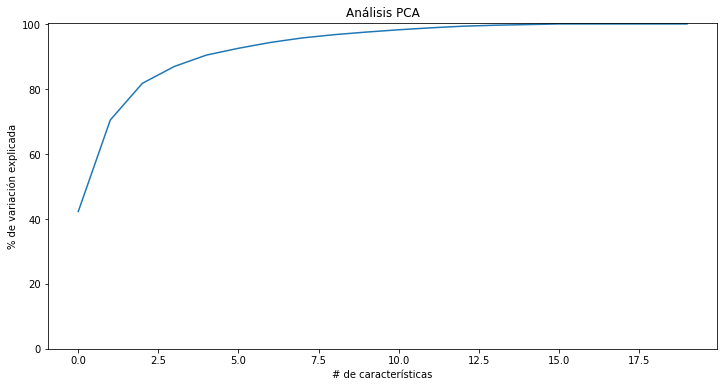

In [ ]:
#Aplico PCA para 20 componentes para evaluar la varianza explicada por cada uno
pca = PCA(n_components=20)
pca.fit(dengue_scaled)
variance = pca.explained_variance_ratio_
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% de variación explicada')
plt.xlabel('# de características')
plt.title('Análisis PCA')
plt.ylim(0,100.5)
plt.plot(var)

### De la gráfica anterior se puede ver que por ejemplo la diferencia entre elegir 2 y 3 componentes a nivel de varianza no es muy significativa (80% frente a un 85% aproximadamente, respectivamente). Pero a nivel de desempeño y debido a la maldición de la dimensionalidad, a medida que se aumenta la dimensionalidad los algoritmos de clustering se comportan peor, por lo que se opta a reducir la dimensionlidad a 2 componentes con el objetivo de realizar una representación de los datos. 

In [ ]:
#Aplicamos PCA de 2 componentes
pca = PCA(n_components=2)
pca.fit(dengue_scaled)
pca_scale = pca.transform(dengue_scaled)
pca_df = pd.DataFrame(pca_scale, columns=['pc1', 'pc2'])
print(pca.explained_variance_ratio_)

[0.42258483 0.28246412]


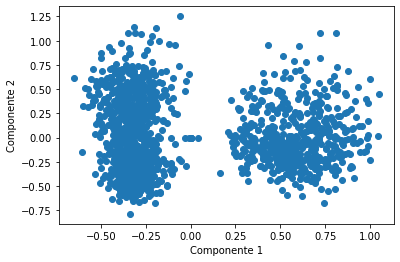

In [ ]:
#Visualizamos los datos
plt.scatter(pca_scale[:, 0], pca_scale[:, 1])
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

### Viendo la representación de los datos se puede apreciar de forma clara dos clústers bien diferenciados, que hacen referencia a las dos ciudades. Un aspecto interesante es que la distribución en ambos casos es diferente, esto podría estar relacionado con la diferencias climáticas de ambas ciudades.

# ANÁLISIS MEDIANTE DBSCAN

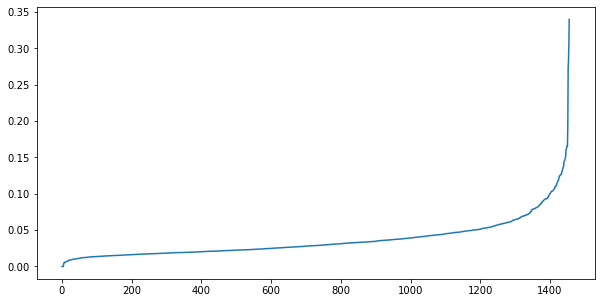

In [ ]:
#Implementación del algoritmo DBSCAN estimando el valor de épsilon con la función de silueta
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(pca_df)
distances, idx = nn.kneighbors(pca_df)
distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.plot(distances)
plt.show()

### Observando la gráfica de la función de silueta parece indicar que el valor óptimo de épsilon podría estar entre 0.1 y 0.3

In [ ]:
db = DBSCAN(eps=0.1, min_samples=5,metric='euclidean').fit(pca_df)
clusters = db.fit_predict(pca_df)

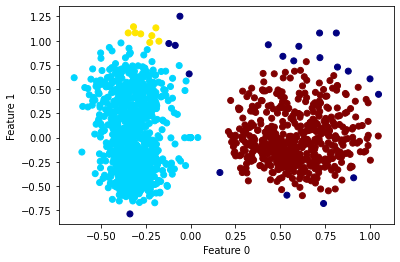

In [ ]:
# Representación de los clusters
plt.scatter(pca_scale[:, 0], pca_scale[:, 1],c=clusters, cmap='jet')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [ ]:
labels = db.labels_
print(Counter(labels))

Counter({0: 927, 2: 501, -1: 20, 1: 8})


In [ ]:
#Número de grupos en las etiquetas, ignorando el ruido si está presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Número de clusters estimados: %d' % n_clusters_)
print('Número de puntos ruidos detectados: %d' % n_noise_)
print("Coeficiente Silhouette: %0.3f" % silhouette_score(pca_df, labels))

Número de clusters estimados: 3
Número de puntos ruidos detectados: 20
Coeficiente Silhouette: 0.433


### Con los parámetros escogidos a priori no se han obtenido buenos resultados, tenemos un coeficiente de silueta muy insignificante. Por lo que vamos a probar un enfoque iterativo con el fin de evaluar el rango detectado en la función de silueta.

In [ ]:
#Enfoque iterativo para intentar afinar más los parámetros
pca_eps_values = np.arange(0.1,0.3,0.01) 
pca_min_samples = np.arange(3,15) 
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []

for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1],metric='euclidean').fit(pca_df)
    if len(set(pca_dbscan_cluster.labels_)) > 1:
        pca_epsvalues.append(p[0])
        pca_min_samp.append(p[1])
        pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
        pca_sil_score.append(silhouette_score(pca_df, pca_dbscan_cluster.labels_))

        pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues, pca_min_samp))

pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['numero_de_clusters', 'silhouette_score', 'valor_epsilon', 'minimo_de_puntos'])

In [ ]:
pca_eps_min_df.loc[pca_eps_min_df['silhouette_score'].idxmax()] #Obtenemos la fila cuyo coeficiente de silueta es mayor

numero_de_clusters    2.000000
silhouette_score      0.542454
valor_epsilon         0.180000
minimo_de_puntos      3.000000
Name: 96, dtype: float64

### En base a los resultados obtenidos, volvemos a ejecutar el algoritmo con los parámetros detectados.

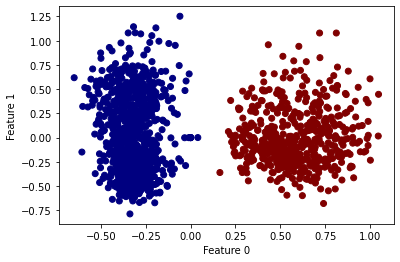

In [ ]:
db = DBSCAN(eps=0.18, min_samples=3,metric='euclidean').fit(pca_df)
clusters = db.fit_predict(pca_df)

# Representación de los clusters
plt.scatter(pca_scale[:, 0], pca_scale[:, 1],c=clusters, cmap='jet')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [ ]:
#Número de grupos en las etiquetas, ignorando el ruido si está presente.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Número de clusters estimados: %d' % n_clusters_)
print('Número de puntos ruidos detectados: %d' % n_noise_)
print("Coeficiente Silhouette: %0.3f" % silhouette_score(pca_df, labels))

Número de clusters estimados: 2
Número de puntos ruidos detectados: 0
Coeficiente Silhouette: 0.542


### Como se puede ver, con este enfoque iterativo, el coeficiente de silueta mejora ligeramente

In [ ]:
labels = db.labels_
print(Counter(labels))

Counter({0: 940, 1: 516})


## CONCLUSIÓN DBSCAN
### Mediante el algoritmo DBSCAN se han encontrado 2 clusters y ningún outliers (lo cual es sospechoso). Los dos clústers encontrados hacen referencia a las ciudades San Jose e Iquitos. De los 2 clústers obtenidos de ambas ciudades, se puede ver en las gráficas mostradas que NO siguen una distribución similar (como vimos con el PCA), lo que invita pensar que en cada ciudad puedan haber a su vez diferentes patrones y, por lo tanto, cada uno de estos clúster se pueda segmentar en más clústers. Aunque para poder probar esta hipótesis no es posible hacerlo utilizando DBSCAN dado que su funcionamiento por densidad y la distribución de los datos lo limita, ya que las instancias en los clústers encontrados están muy juntos, lo que imposibilita conseguir una mejor clusterización.

### Como posible solución vamos a optar por utilizar un algoritmo probabilístico, concretamente el GMM (Gaussian Mixture Models)

# ANÁLISIS MEDIANTE GMM

### Al tratarse de un problema NO supervisado, no hay forma de conocer de antemano el número de componentes y tipo de matriz de covarianz óptimos. Afortunadamente, al ser un modelo probabilístico, se puede recurrir a métricas como el Akaike information criterion (AIC) o Bayesian information criterion (BIC) para identificar cómo de bien se ajustan los datos observados al modelo creado, a la vez que se controla el exceso de overffiting. En la implementación de Scikit-learn, para ambas métricas, cuanto más bajo el valor, mejor.

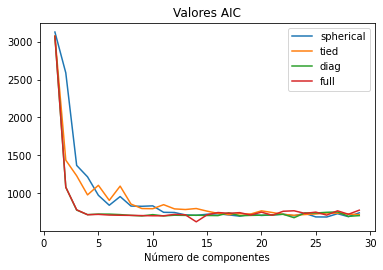

In [ ]:
ig, ax = plt.subplots(figsize=(6, 3.84))

n_components = range(1, 30)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_aic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(pca_df)
        valores_aic.append(modelo.aic(pca_df))
        
    ax.plot(n_components, valores_aic, label=covariance_type)
        
ax.set_title("Valores AIC")
ax.set_xlabel("Número de componentes")
ax.legend()

### Vemos que los mejores resultados son con los parámetros --> num_componentes = 6 y una covarianza de tipo full

In [ ]:
modelo_gmm = GaussianMixture(
                n_components    = 6,
                covariance_type = 'full',
                random_state    = 0
             )

modelo_gmm.fit(X=pca_df)

GaussianMixture(n_components=6, random_state=0)

In [ ]:
# Predicción log probabilidad
log_probabilidad_predicha = modelo_gmm.score_samples(X=pca_df)
log_probabilidad_predicha

array([-1.13958574e-01,  5.02873729e-01,  3.39463350e-01, ...,
       -1.77737562e+00, -9.95964320e-01,  1.27243298e-04])

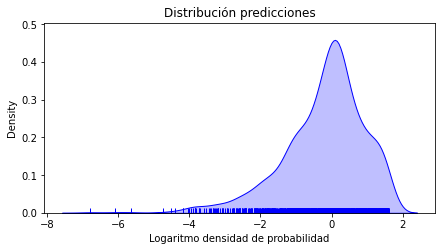

In [ ]:
# Distribución de las probabilidades (log density)
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    log_probabilidad_predicha,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.set_title('Distribución predicciones')
ax.set_xlabel('Logaritmo densidad de probabilidad');

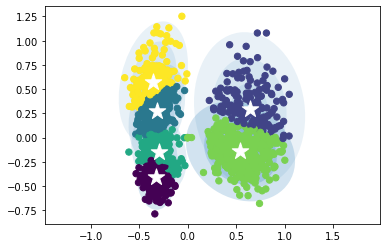

In [ ]:
plot_gmm(modelo_gmm, pca_scale, label=True)

### Con el GMM se ha podido confirmar que puesto que se trata de dos ciudades ubicadas en diferentes países es muy probable que tengan distintas condiciones, lo que se refleja en las agrupaciones obtenidas. Esto apunta a que para cada una de ellas tendrán características influyentes diferentes. Por lo que en base a ello, se va a optar por separar/tratar ambas ciudades por separado y así detectar aquellas características de cada ciudad más relevantes.

# DIVISIÓN DEL DATASET 
## Como se ha podido verificar, el dataset hacen referencia a dos ciudades, por lo que creemos conveniente separarlos y trabajar de forma independizada.

In [ ]:
dengue = dengue.reset_index()
dengue = dengue.set_index(['weekofyear','year'])
df_sj = dengue[dengue['city'] == 'sj']
df_iq = dengue[dengue['city'] == 'iq']
df_sj.drop(['city'], axis = 1, inplace = True)
df_iq.drop(['city'], axis = 1, inplace = True)

In [ ]:
df_sj.head(5)

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
weekofyear year                                                                 
18         1990  0.122600  0.103725  0.198483  0.177617                 12.42   
19         1990  0.169900  0.142175  0.162357  0.155486                 22.82   
20         1990  0.032250  0.172967  0.157200  0.170843                 34.54   
21         1990  0.128633  0.245067  0.227557  0.235886                 15.36   
22         1990  0.196200  0.262200  0.251200  0.247340                  7.52   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
weekofyear year                                                 
18         1990             297.572857             297.742857   
19         1990             298.211429             298.442857   
20         1990             298.781429             298.878571   
21         1990             298.987143             299.228571   
22         1990             299.518571             299.664286   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
weekofyear year                                                           
18         1990                   292.414286                      299.8   
19         1990                   293.951429                      300.9   
20         1990                   295.434286                      300.5   
21         1990                   295.310000                      301.4   
22         1990                   295.821429                      301.9   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
weekofyear year                                                               
18         1990                      295.9                            32.00   
19         1990                      296.4                            17.94   
20         1990                      297.3                            26.10   
21         1990                      297.0                            13.90   
22         1990                      297.5                            12.20   

                 reanalysis_relative_humidity_percent  \
weekofyear year                                         
18         1990                             73.365714   
19         1990                             77.368571   
20         1990                             82.052857   
21         1990                             80.337143   
22         1990                             80.460000   

                 reanalysis_sat_precip_amt_mm  \
weekofyear year                                 
18         1990                         12.42   
19         1990                         22.82   
20         1990                         34.54   
21         1990                         15.36   
22         1990                          7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
weekofyear year                                                             
18         1990                              14.012857           2.628571   
19         1990                              15.372857           2.371429   
20         1990                              16.848571           2.300000   
21         1990                              16.672857           2.428571   
22         1990                              17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
weekofyear year                                                
18         1990           25.442857                 6.900000   
19         1990           26.714286                 6.371429   
20         1990           26.714286                 6.485714   
21         1990           27.471429                 6.771429   
22         1990           28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
weekofyear year                                                             
18         1990            

In [ ]:
df_iq.head(5)

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
weekofyear year                                                                 
26         2000  0.192886  0.132257  0.340886  0.247200                 25.41   
27         2000  0.216833  0.276100  0.289457  0.241657                 60.61   
28         2000  0.176757  0.173129  0.204114  0.128014                 55.52   
29         2000  0.227729  0.145429  0.254200  0.200314                  5.60   
30         2000  0.328643  0.322129  0.254371  0.361043                 62.76   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
weekofyear year                                                 
26         2000             296.740000             298.450000   
27         2000             296.634286             298.428571   
28         2000             296.415714             297.392857   
29         2000             295.357143             296.228571   
30         2000             296.432857             297.635714   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
weekofyear year                                                           
26         2000                   295.184286                      307.3   
27         2000                   295.358571                      306.6   
28         2000                   295.622857                      304.5   
29         2000                   292.797143                      303.6   
30         2000                   293.957143                      307.0   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
weekofyear year                                                               
26         2000                      293.1                            43.19   
27         2000                      291.1                            46.00   
28         2000                      292.6                            64.77   
29         2000                      288.6                            23.96   
30         2000                      291.5                            31.80   

                 reanalysis_relative_humidity_percent  \
weekofyear year                                         
26         2000                             92.418571   
27         2000                             93.581429   
28         2000                             95.848571   
29         2000                             87.234286   
30         2000                             88.161429   

                 reanalysis_sat_precip_amt_mm  \
weekofyear year                                 
26         2000                         25.41   
27         2000                         60.61   
28         2000                         55.52   
29         2000                          5.60   
30         2000                         62.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
weekofyear year                                                             
26         2000                              16.651429           8.928571   
27         2000                              16.862857          10.314286   
28         2000                              17.120000           7.385714   
29         2000                              14.431429           9.114286   
30         2000                              15.444286           9.500000   

                 station_avg_temp_c  station_diur_temp_rng_c  \
weekofyear year                                                
26         2000           26.400000                10.775000   
27         2000           26.900000                11.566667   
28         2000           26.800000                11.466667   
29         2000           25.766667                10.533333   
30         2000           26.600000                11.480000   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
weekofyear year                                                             
26         2000            

In [ ]:
#Guardamos las columnas de ambos dataset
columns_sj = df_sj.columns
columns_iq = df_iq.columns

In [ ]:
columns_sj

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [ ]:
columns_iq

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

# SELECCIÓN DE CARACTERÍSTICAS MEDIANTE ANÁLISIS DE CORRELACIÓN

## En este apartado se va a realizar un estudio de correlaciones, con el fin de realizar una selección de características, identificando aquellas redundantes. De  esta forma, en caso de existir se podrían eliminar algunas y por lo tanto reducir la dimensionalidad y aumentar el rendimiento del algoritmo.

## SJ

In [ ]:
feat_sj = transpose(df_sj)
names_sj = feat_sj.index

feat_sj.head()

weekofyear                   18         19         20         21       22  \
year                       1990       1990       1990       1990     1990   
ndvi_ne                0.122600   0.169900   0.032250   0.128633  0.19620   
ndvi_nw                0.103725   0.142175   0.172967   0.245067  0.26220   
ndvi_se                0.198483   0.162357   0.157200   0.227557  0.25120   
ndvi_sw                0.177617   0.155486   0.170843   0.235886  0.24734   
precipitation_amt_mm  12.420000  22.820000  34.540000  15.360000  7.52000   

weekofyear                  23        24          25         26         27  \
year                      1990      1990        1990       1990       1990   
ndvi_ne               0.142294  0.112900    0.072500   0.102450   0.142294   
ndvi_nw               0.174850  0.092800    0.072500   0.146175   0.121550   
ndvi_se               0.254314  0.205071    0.151471   0.125571   0.160683   
ndvi_sw               0.181743  0.210271    0.133029   0.123600   0.202567   
precipitation_amt_mm  9.580000  3.480000  151.120000  19.320000  14.410000   

weekofyear            ...        8         9         10        11        12  \
year                  ...      2008      2008      2008      2008      2008   
ndvi_ne               ... -0.138650  0.142294 -0.088900 -0.321400  0.044900   
ndvi_nw               ... -0.095067  0.015420 -0.090033 -0.141200  0.024450   
ndvi_se               ...  0.246057  0.211629  0.223243  0.110643  0.101629   
ndvi_sw               ...  0.228129  0.117343  0.154186  0.141014  0.088000   
precipitation_amt_mm  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

weekofyear                   13        14         15        16        17  
year                       2008      2008       2008      2008      2008  
ndvi_ne                0.077850 -0.038000  -0.155200  0.001800 -0.037000  
ndvi_nw               -0.039900 -0.016833  -0.052750  0.130553 -0.010367  
ndvi_se                0.310471  0.119371   0.137757  0.203900  0.077314  
ndvi_sw                0.296243  0.066386   0.141214  0.209843  0.090586  
precipitation_amt_mm  27.190000  3.820000  16.960000  0.000000  0.000000  

[5 rows x 936 columns]

<AxesSubplot:>

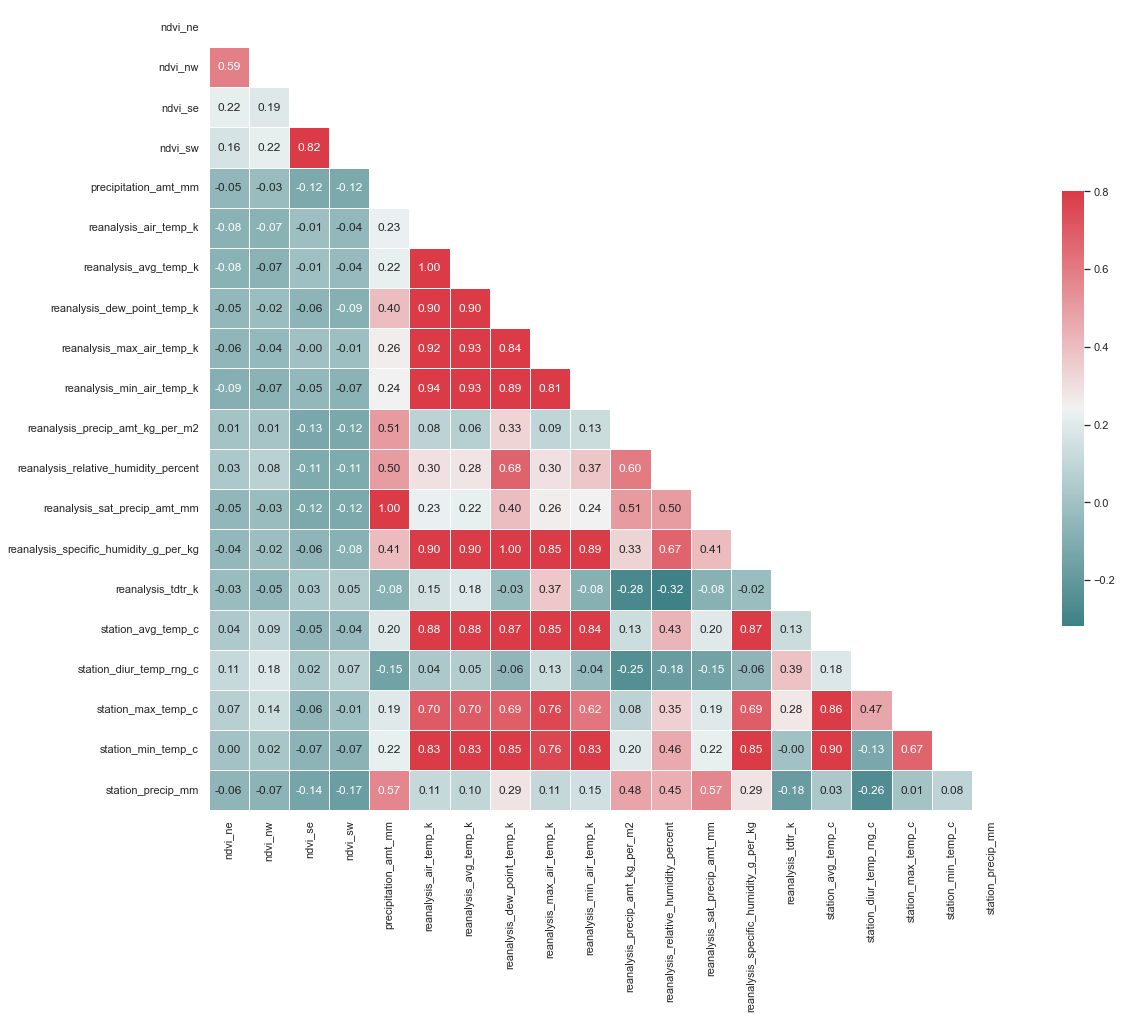

In [ ]:
#Calculamos la matriz de correlaciones
R_sj = corrcoef(feat_sj)

sns.set(style="white")
mask = np.zeros_like(R_sj, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 16))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R_sj, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_sj, yticklabels=names_sj, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### De la imagen anterior se puede observar a primera vista la existencia de algunas características correlacionadas. Para una apreciación más clara se procede aquellas correlaciones superiores al 0.90

<AxesSubplot:>

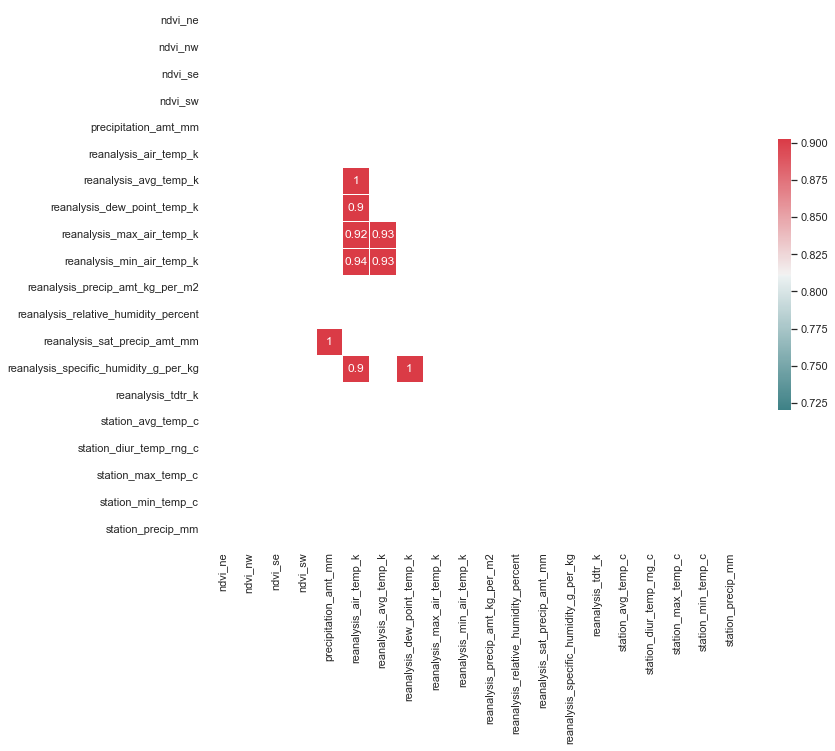

In [ ]:
R1_sj = R_sj
for i in range(len(R1_sj)):
  for j in range(len(R1_sj)):
    if abs(R1_sj[i,j]) >= 0.9:
      R1_sj[i,j] = abs(R1_sj[i,j])
    else:
      R1_sj[i,j] = 'NaN'

sns.set(style="white")
mask = np.zeros_like(R1_sj, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R1_sj, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_sj, yticklabels=names_sj, annot=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Del anterior gráfico se observa la existencia de una correlación muy alta entre las características:
- reanalysis_avg_temp_k --> reanalysis_air_temp_k
- reanalysis_dew_point_temp_k --> reanalysis_air_temp_k
- reanalysis_max_air_temp_k -->reanalysis_air_temp_k
- reanalysis_min_air_temp_k --> reanalysis_air_temp_k
- reanalysis_max_air_temp_k --> reanalysis_avg_temp_k
- reanalysis_min_air_temp_k --> reanalysis_avg_temp_k
- reanalysis_sat_precip_amt_mm --> precipitation_amt_mm
- reanalysis_specific_humidity_g_per_kg --> reanalysis_air_temp_k
- reanalysis_specific_humidity_g_per_kg --> reanalysis_dew_point_temp_k

### Por lo tanto, en base esto, se procede a eliminar aquellas características que hemos visto que tienen una fuerte correlación y por lo tanto son redundantes.

In [ ]:
df_sj.drop(['reanalysis_air_temp_k','precipitation_amt_mm','reanalysis_avg_temp_k','reanalysis_dew_point_temp_k'],axis=1,inplace=True)

## IQ

In [ ]:
feat_iq = transpose(df_iq)
names_iq = feat_iq.index

feat_iq.head()

weekofyear                   26         27         28        29         30  \
year                       2000       2000       2000      2000       2000   
ndvi_ne                0.192886   0.216833   0.176757  0.227729   0.328643   
ndvi_nw                0.132257   0.276100   0.173129  0.145429   0.322129   
ndvi_se                0.340886   0.289457   0.204114  0.254200   0.254371   
ndvi_sw                0.247200   0.241657   0.128014  0.200314   0.361043   
precipitation_amt_mm  25.410000  60.610000  55.520000  5.600000  62.760000   

weekofyear                   31         32         33         34         35  \
year                       2000       2000       2000       2000       2000   
ndvi_ne                0.205529   0.312486   0.384133   0.408157   0.332043   
ndvi_nw                0.190757   0.329986   0.392240   0.322157   0.321057   
ndvi_se                0.231671   0.380586   0.341780   0.406714   0.314614   
ndvi_sw                0.255314   0.387271   0.382750   0.302714   0.324257   
precipitation_amt_mm  16.240000  89.370000  42.080000  49.220000  53.650000   

weekofyear            ...         16         17         18         19  \
year                  ...       2010       2010       2010       2010   
ndvi_ne               ...   0.231486   0.239743   0.260814   0.168686   
ndvi_nw               ...   0.294686   0.259271   0.255786   0.158500   
ndvi_se               ...   0.331657   0.307786   0.257771   0.133071   
ndvi_sw               ...   0.244400   0.307943   0.340286   0.145600   
precipitation_amt_mm  ...  86.700000  26.000000  73.970000  59.400000   

weekofyear                  20         21         22         23         24  \
year                      2010       2010       2010       2010       2010   
ndvi_ne               0.263071   0.342750   0.160157   0.247057   0.333914   
ndvi_nw               0.272500   0.318900   0.160371   0.146057   0.245771   
ndvi_se               0.258271   0.256343   0.136043   0.250357   0.278886   
ndvi_sw               0.244500   0.292514   0.225657   0.233714   0.325486   
precipitation_amt_mm  1.150000  55.300000  86.470000  58.940000  59.670000   

weekofyear                   25  
year                       2010  
ndvi_ne                0.298186  
ndvi_nw                0.232971  
ndvi_se                0.274214  
ndvi_sw                0.315757  
precipitation_amt_mm  63.220000  

[5 rows x 520 columns]

<AxesSubplot:>

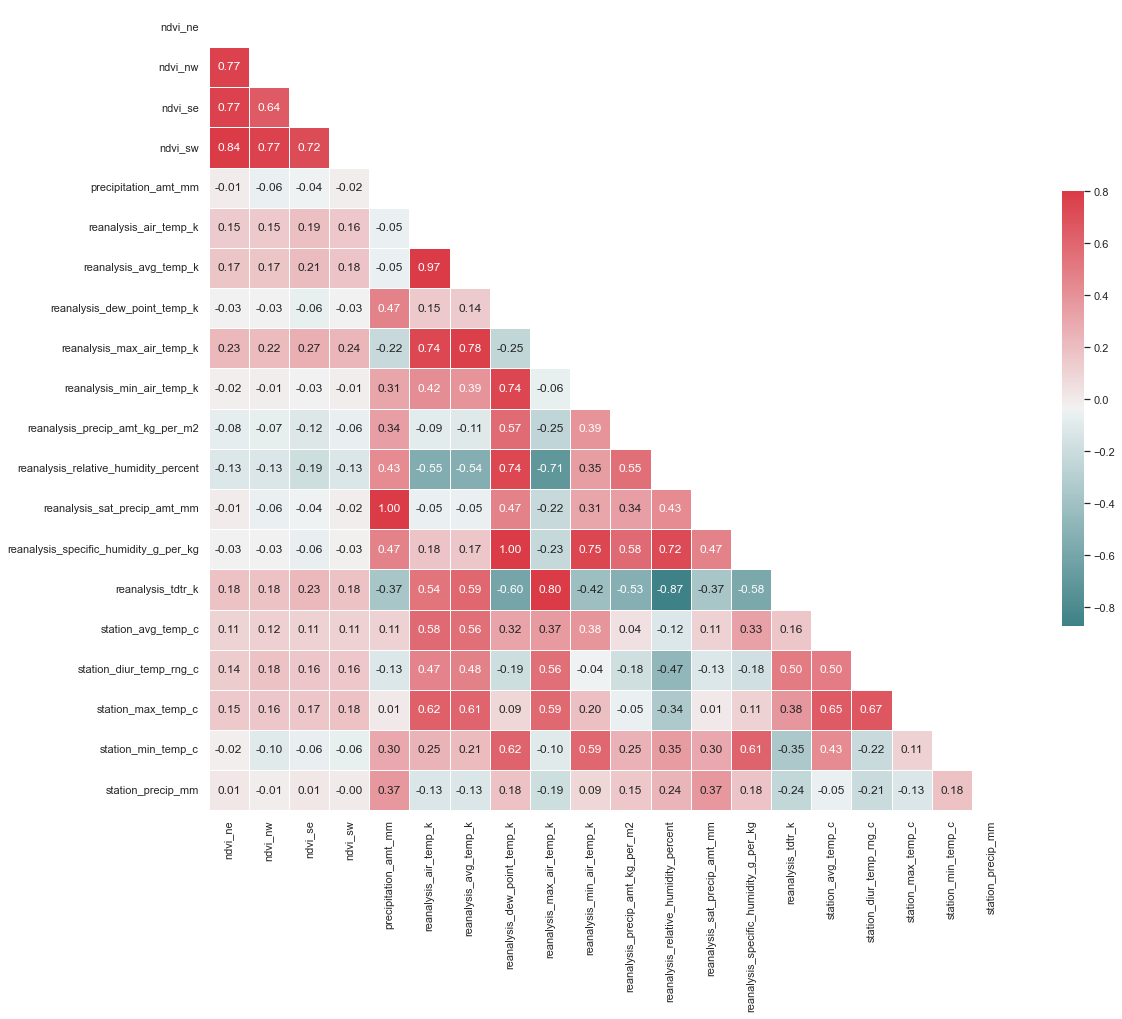

In [ ]:
#Calculamos la matriz de correlación para los datos de la ciudad IQ
R_iq = corrcoef(feat_iq)

sns.set(style="white")
mask = np.zeros_like(R_iq, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 16))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R_iq, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_iq, yticklabels=names_iq, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### En este caso también hay características correlacionadas, aunque parece haber un número menor.

<AxesSubplot:>

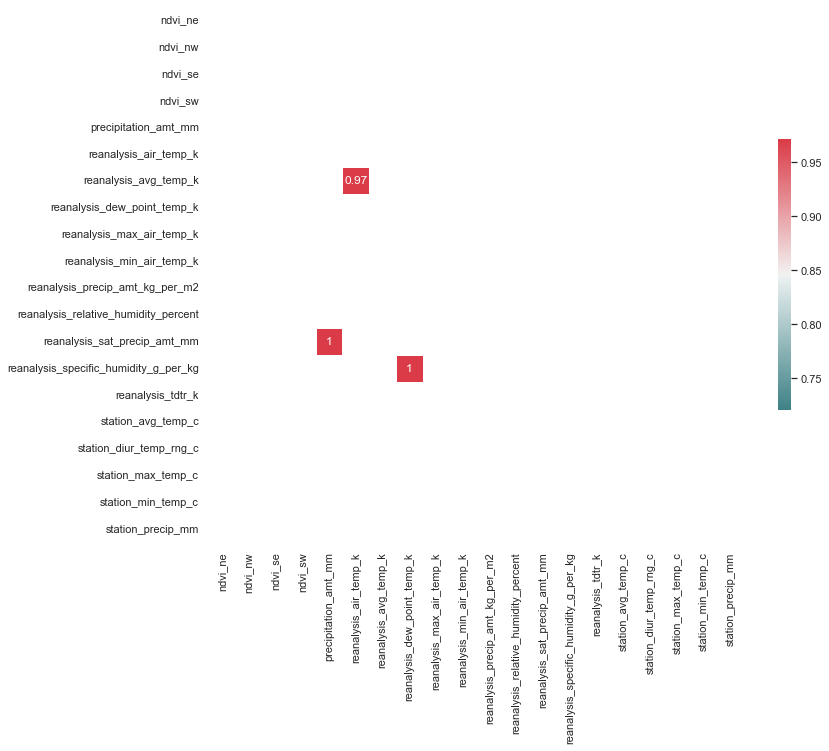

In [ ]:
R1_iq = R_iq
for i in range(len(R1_iq)):
  for j in range(len(R1_iq)):
    if abs(R1_iq[i,j]) >= 0.9:
      R1_iq[i,j] = abs(R1_iq[i,j])
    else:
      R1_iq[i,j] = 'NaN'

sns.set(style="white")
mask = np.zeros_like(R1_iq, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R1_iq, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_iq, yticklabels=names_iq, annot=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Del anterior gráfico se observa la existencia de una correlación muy alta entre las características:
- reanalysis_avg_temp_k --> reanalysis_air_temp_k
- reanalysis_sat_precip_amt_mm --> precipitation_amt_mm
- reanalysis_specific_humidity_g_per_kg --> reanalysis_dew_point_temp_k

### Por lo tanto, en base esto, se procede a eliminar aquellas características que hemos visto que tienen una fuerte correlación y por lo tanto son redundantes.

In [ ]:
df_iq.drop(['reanalysis_air_temp_k','precipitation_amt_mm','reanalysis_dew_point_temp_k'],axis=1,inplace=True)

## Una vez que tenemos ambos dataset limpios de características redundantes se va a proceder a aplicar una PCA con el objetivo de obtener aquellas características más relevantes para el problema.

# APLICACIÓN DE PCA PARA LA SELECCIÓN DE CARACTERÍSTICAS MÁS RELEVANTES

## SJ

In [ ]:
feat_sj = transpose(df_sj)
names_sj = feat_sj.index

### Aplicamos PCA, para ello vamos a establecer un umbral de varianza explicada del 90%

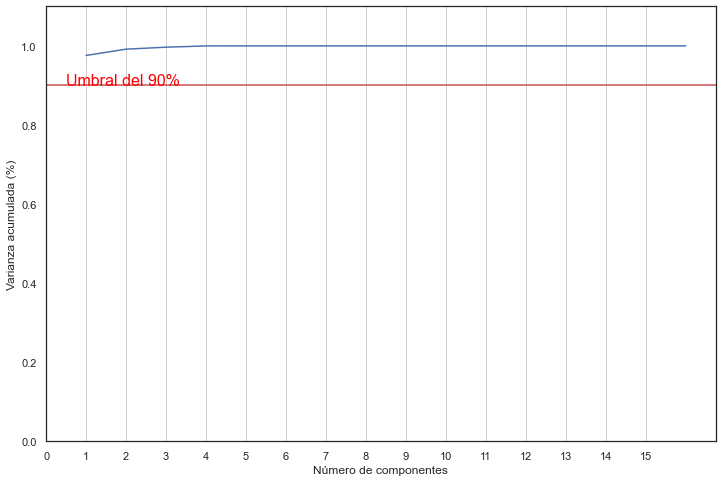

In [ ]:
pca_sj = PCA().fit(feat_sj)

plt.rcParams["figure.figsize"] = (16,10)

fig, ax = plt.subplots(figsize=(12,8))
xi = np.arange(1, len(names_sj) + 1, 1)
y = np.cumsum(pca_sj.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Número de componentes')
plt.xticks(np.arange(0, len(names_sj), 1))
plt.ylabel('Varianza acumulada (%)')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.90, 'Umbral del 90%', color = 'red', fontsize=16)

ax.grid(axis='x')

plt.show()

Proporción de varianza explicada:  [0.97805033 0.01486899 0.00407622]


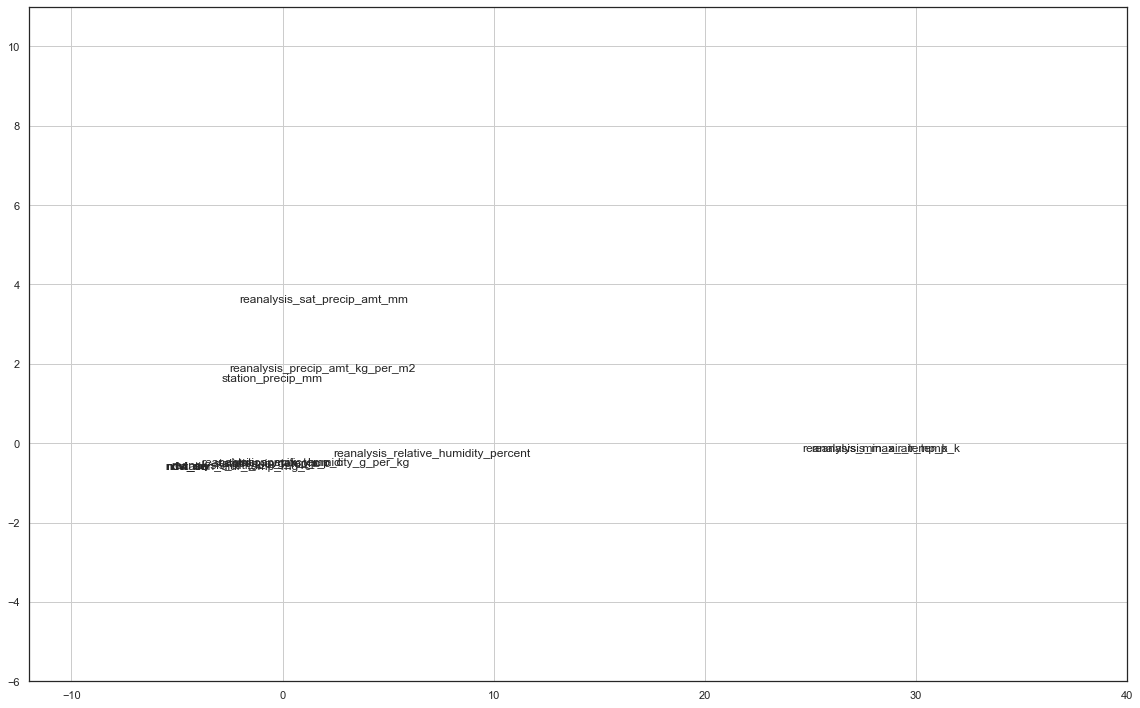

In [ ]:
min_max_scaler = MinMaxScaler()
norm_sj = min_max_scaler.fit_transform(feat_sj)

estimator_sj = PCA (n_components=3)
X_pca_sj = estimator_sj.fit_transform(norm_sj)
print("Proporción de varianza explicada: ", estimator_sj.explained_variance_ratio_) 

fig, ax = plt.subplots()
for i in range(len(X_pca_sj)):
    plt.text(X_pca_sj[i][0], X_pca_sj[i][1], names_sj[i]) 


plt.xlim(-12, 40)
plt.ylim(-6, 11)
ax.grid(True)
fig.tight_layout()
plt.show()

## IQ

In [ ]:
feat_iq = transpose(df_iq)
names_iq = feat_iq.index

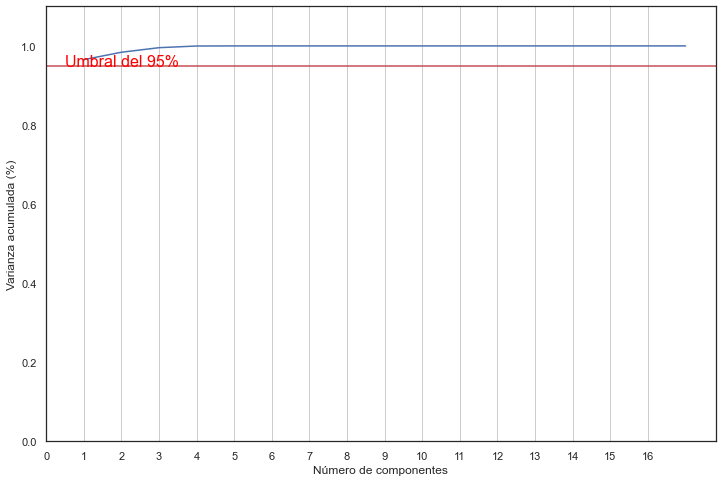

In [ ]:
pca_iq = PCA().fit(feat_iq)

plt.rcParams["figure.figsize"] = (16,10)

fig, ax = plt.subplots(figsize=(12,8))
xi = np.arange(1, len(names_iq) + 1, 1)
y = np.cumsum(pca_iq.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Número de componentes')
plt.xticks(np.arange(0, len(names_iq), 1))
plt.ylabel('Varianza acumulada (%)')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.95, 'Umbral del 95%', color = 'red', fontsize=16)

ax.grid(axis='x')

plt.show()

Proporción de varianza explicada:  [0.96687725 0.01739998 0.01129441]


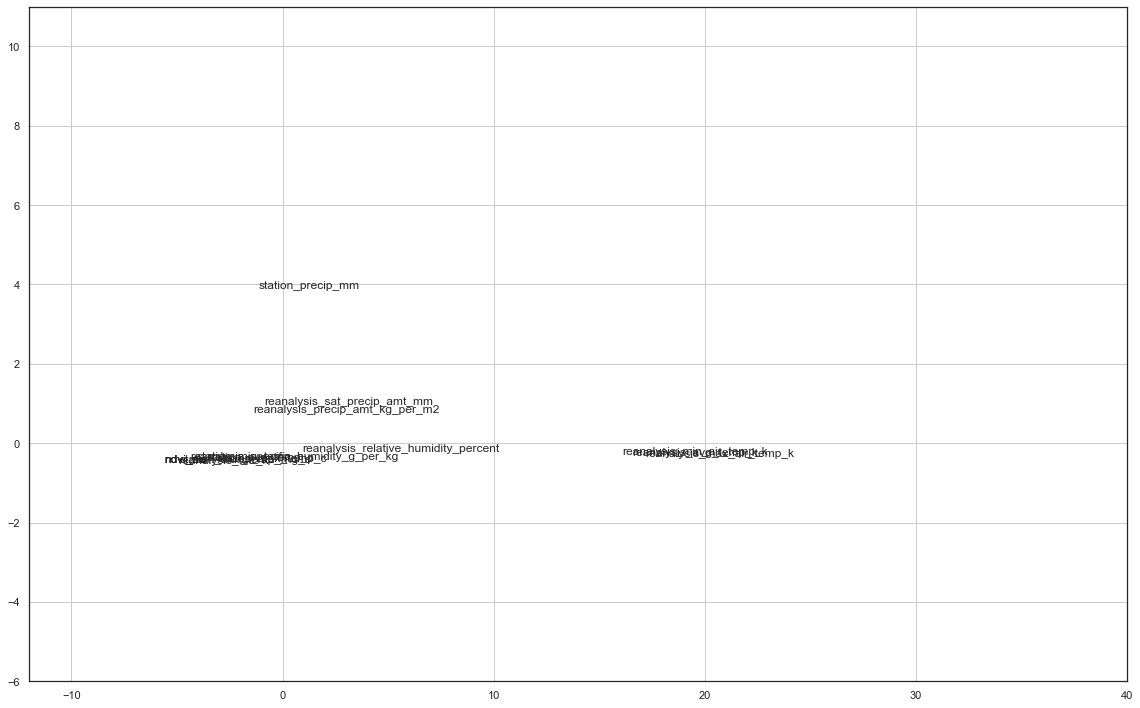

In [ ]:
norm_iq = min_max_scaler.fit_transform(feat_iq) #Se escalan los datos

estimator_iq = PCA (n_components=3)
X_pca_iq = estimator_iq.fit_transform(norm_iq)
print("Proporción de varianza explicada: ", estimator_iq.explained_variance_ratio_) 

fig, ax = plt.subplots()
for i in range(len(X_pca_iq)):
    plt.text(X_pca_iq[i][0], X_pca_iq[i][1], names_iq[i]) 


plt.xlim(-12, 40)
plt.ylim(-6, 11)
ax.grid(True)
fig.tight_layout()
plt.show()

# SELECCIÓN DE CARACTERÍSTICAS MEDIANTE CLÚSTERING JERÁRQUICO

### Con el fin de reforzar las conclusiones de las características estudiadas con la PCA, se va a proceder a realizar un clustering jerárquico.

## SJ

<AxesSubplot:>

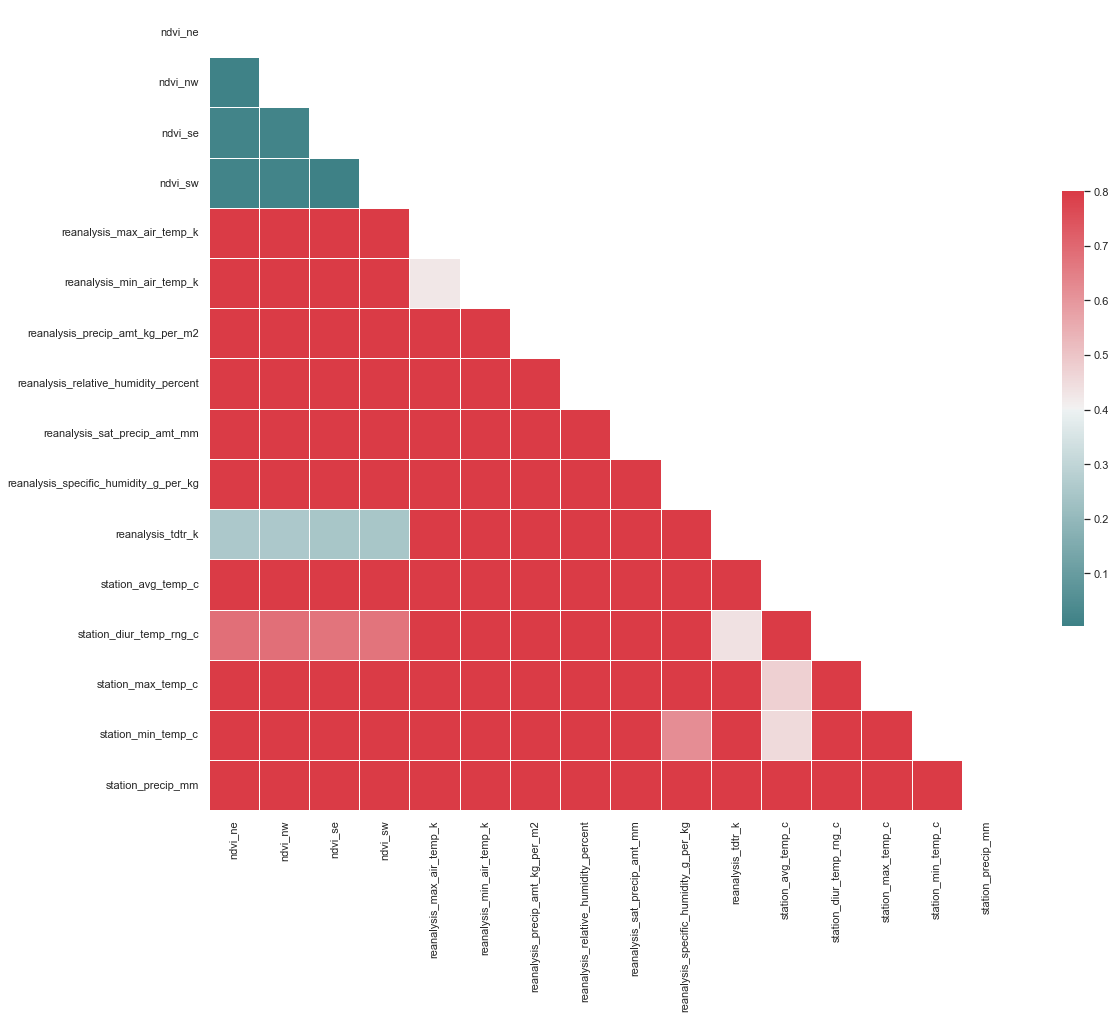

In [ ]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist_sj= dist.pairwise(norm_sj)
sns.set(style="white")
mask = np.zeros_like(matdist_sj, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 16))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(matdist_sj, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_sj, yticklabels=names_sj,  
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Del gráfico anterior se pueden diferenciar algunas características alejadas, como son:

- ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw
- reanalysis_min_air_temp_k, reanalysis_max_air_temp_k
- reanalysis_tdtr_k
- station_diur_temp_mg_c
- station_max_temp_c, station_avg_temp_c
- station_min_temp_c, station_avg_temp_c

### Para verlo más claro, mostramos el dendrograma.

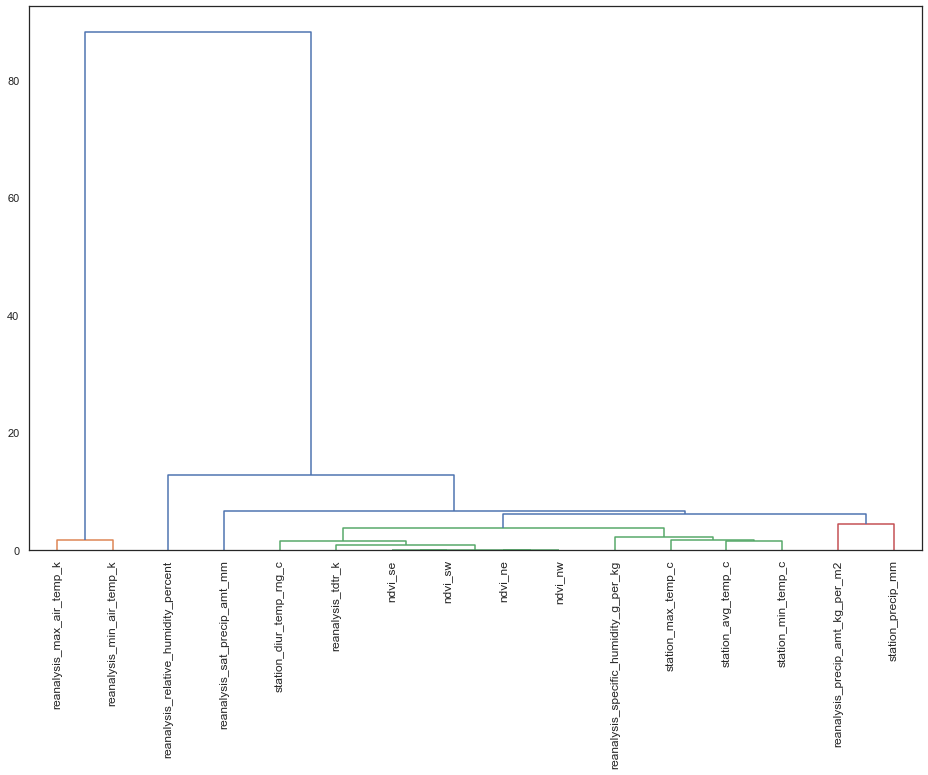

In [ ]:
clusters_sj = cluster.hierarchy.linkage(matdist_sj, method = 'single')
cluster.hierarchy.dendrogram(clusters_sj, color_threshold = 5, labels = names_sj , leaf_rotation=90) #Apliamos el corte en 5
plt.show()

### Representamos a continuación una PCA para 5 clústers.

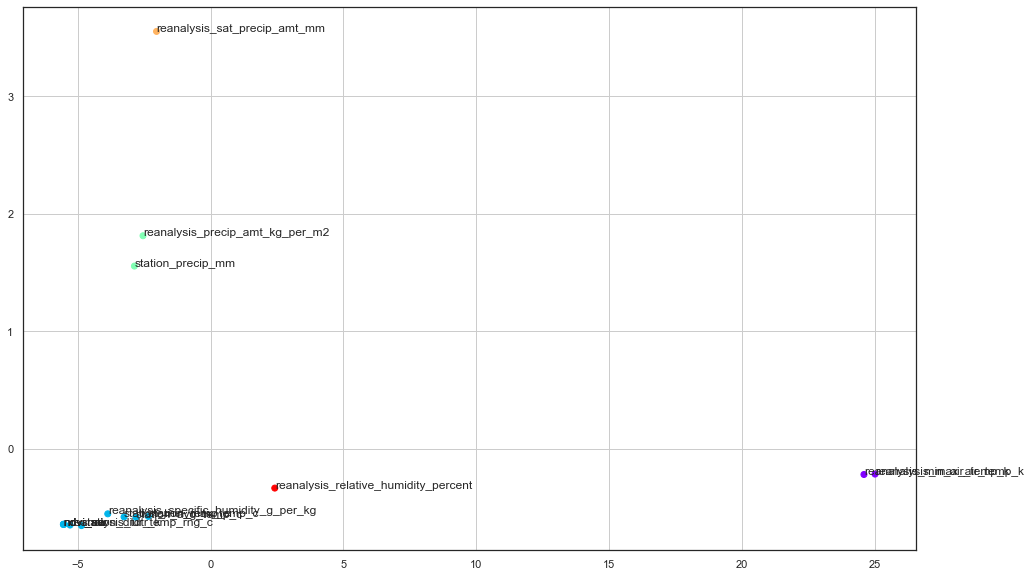

In [ ]:
labels_sj = cluster.hierarchy.fcluster(clusters_sj, 5 , criterion = 'maxclust')

plt.scatter(X_pca_sj[:,0], X_pca_sj[:,1], c = labels_sj, cmap = 'rainbow')
for i in range(len(X_pca_sj)):
    plt.text(X_pca_sj[i][0], X_pca_sj[i][1], names_sj[i]) 

plt.grid()
plt.show()

### Se observan que existen características aglutinadas y otras muy dispersas, estas últimas son las que más podrían aportar información. Respecto a las aglutinadas, se escogeran al azar unas de este grupo como primer punto de partida. 

### En base al estudio anterior realizado sobre la ciudad SJ una posible selección de características podría ser la siguiente:

- reanalysis_relative_humidity_percent
- ndvi_ne
- station_precip_mm
- reanalysis_sat_precip_amt_mm
- station_diur_temp_mg_c
- reanalysis_specific_humidity_g_per_kg


In [ ]:
features_final_sj = ['reanalysis_relative_humidity_percent','ndvi_ne','station_precip_mm','reanalysis_sat_precip_amt_mm','station_diur_temp_rng_c','reanalysis_specific_humidity_g_per_kg']
df_final_sj = df_sj[features_final_sj]

## IQ

<AxesSubplot:>

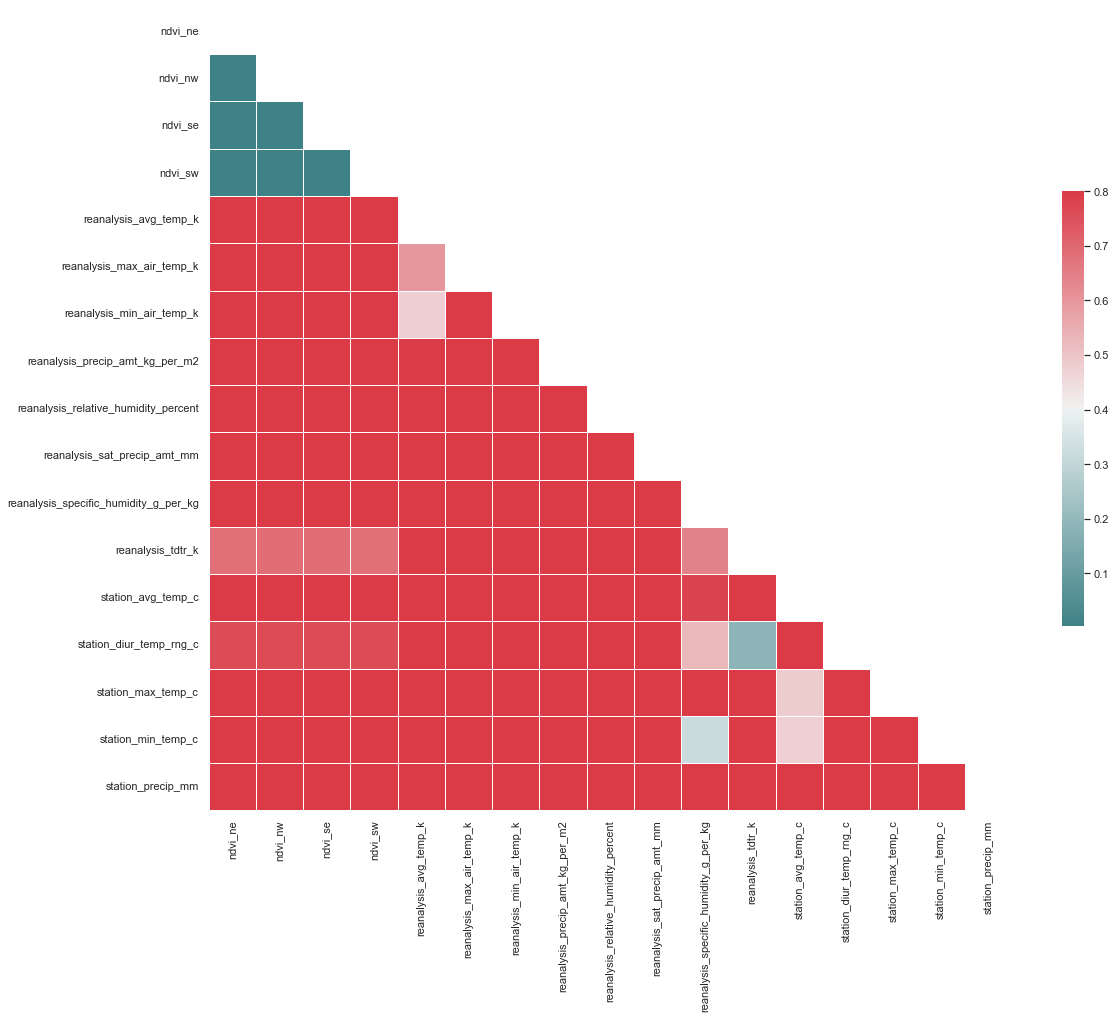

In [ ]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist_iq= dist.pairwise(norm_iq)
sns.set(style="white")
mask = np.zeros_like(matdist_iq, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 16))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(matdist_iq, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names_iq, yticklabels=names_iq,  
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Del gráfico anterior se pueden diferenciar algunas características alejadas, como son:

- ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw
- reanalysis_max_air_temp_k --> reanalysis_avg_temp_k
- reanalysis_min_air_temp_k --> reanalysis_avg_temp_k
- reanalysis_tdtr_k --> reanalysis_specific_humidity_g_per_kg
- station_diur_temp_mg_c --> reanalysis_tdtr_k
- station_max_temp_c --> station_avg_temp_c
- station_min_temp_c --> station_avg_temp_c

### Para verlo más claro, mostramos el dendrograma.

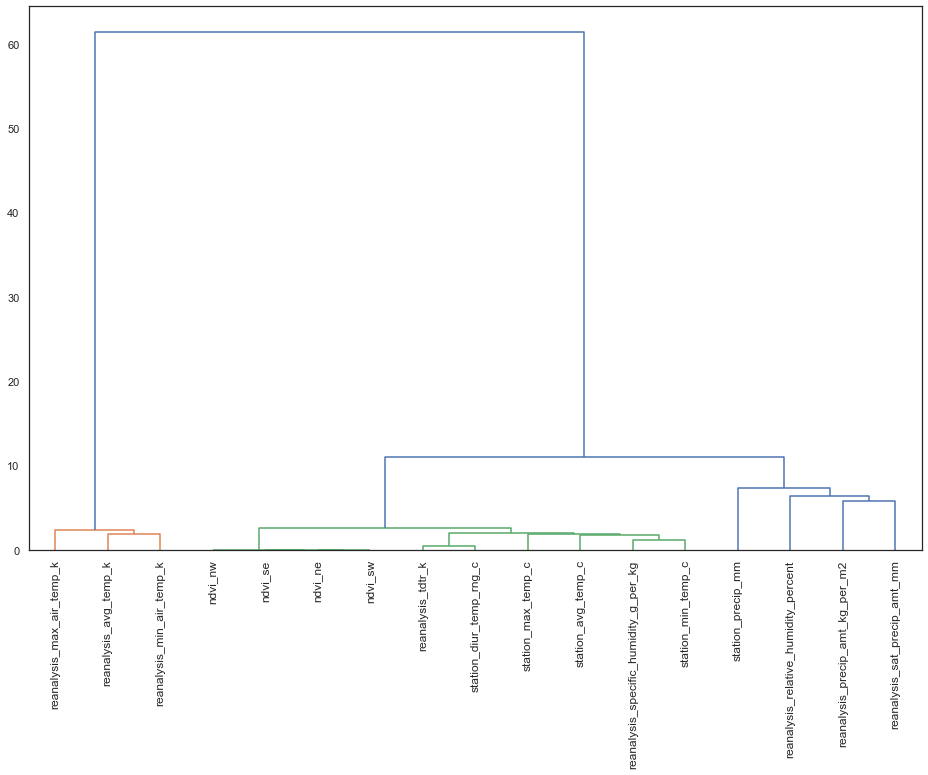

In [ ]:
clusters_iq = cluster.hierarchy.linkage(matdist_iq, method = 'single')
cluster.hierarchy.dendrogram(clusters_iq, color_threshold = 5, labels = names_iq , leaf_rotation=90)
plt.show()

### Representamos a continuación una PCA para 5 clústers.

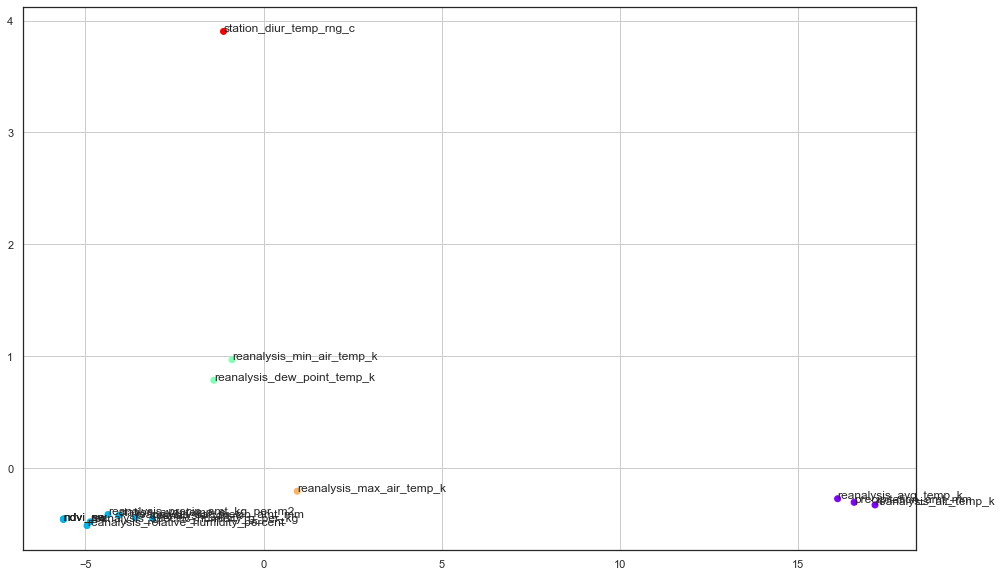

In [ ]:
labels_iq = cluster.hierarchy.fcluster(clusters_iq, 5 , criterion = 'maxclust')

plt.scatter(X_pca_iq[:,0], X_pca_iq[:,1], c = labels_iq, cmap = 'rainbow')
for i in range(len(X_pca_iq)):
    plt.text(X_pca_iq[i][0], X_pca_iq[i][1], columns_iq[i]) 

plt.grid()
plt.show()

### Se observan que existen características aglutinadas y otras muy dispersas, estas últimas son las que más podrían aportar información. Respecto a las aglutinadas, se escogeran al azar unas de este grupo como primer punto de partida. 
### En base al estudio anterior realizado sobre la ciudad IQ una posible selección de características podría ser la siguiente:

- reanalysis_min_air_temp_k
- ndvi_ne
- station_diur_temp_rng_c
- station_precip_mm
- reanalysis_specific_humidity_g_per_kg
- reanalysis_precip_amt_kg_per_m2

In [ ]:
features_final_iq = ['reanalysis_min_air_temp_k','ndvi_ne','station_diur_temp_rng_c','station_precip_mm','reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
df_final_iq = df_iq[features_final_iq]

# DATASETS FINALES

## SJ

In [ ]:
df_final_sj.head(5)

reanalysis_relative_humidity_percent   ndvi_ne  \
weekofyear year                                                   
18         1990                             73.365714  0.122600   
19         1990                             77.368571  0.169900   
20         1990                             82.052857  0.032250   
21         1990                             80.337143  0.128633   
22         1990                             80.460000  0.196200   

                 station_precip_mm  reanalysis_sat_precip_amt_mm  \
weekofyear year                                                    
18         1990               16.0                         12.42   
19         1990                8.6                         22.82   
20         1990               41.4                         34.54   
21         1990                4.0                         15.36   
22         1990                5.8                          7.52   

                 station_diur_temp_rng_c  \
weekofyear year                            
18         1990                 6.900000   
19         1990                 6.371429   
20         1990                 6.485714   
21         1990                 6.771429   
22         1990                 9.371429   

                 reanalysis_specific_humidity_g_per_kg  
weekofyear year                                         
18         1990                              14.012857  
19         1990                              15.372857  
20         1990                              16.848571  
21         1990                              16.672857  
22         1990                              17.210000

## IQ

In [ ]:
df_final_iq.head(5)

reanalysis_min_air_temp_k   ndvi_ne  station_diur_temp_rng_c  \
weekofyear year                                                                 
26         2000                      293.1  0.192886                10.775000   
27         2000                      291.1  0.216833                11.566667   
28         2000                      292.6  0.176757                11.466667   
29         2000                      288.6  0.227729                10.533333   
30         2000                      291.5  0.328643                11.480000   

                 station_precip_mm  reanalysis_specific_humidity_g_per_kg  \
weekofyear year                                                             
26         2000                3.0                              16.651429   
27         2000               55.6                              16.862857   
28         2000               38.1                              17.120000   
29         2000               30.0                              14.431429   
30         2000                4.0                              15.444286   

                 reanalysis_precip_amt_kg_per_m2  
weekofyear year                                   
26         2000                            43.19  
27         2000                            46.00  
28         2000                            64.77  
29         2000                            23.96  
30         2000                            31.80

# RESUMEN Y CONCLUSIONES

## Se pasa a detallar en esta última sección un resumen de las acciones llevadas a cabo, así como las conclusiones finales.

### RESUMEN

El primer paso llevado a cabo fue una pequeña limpieza de datos, en donde en esta fase se pudo observar que existían varios missing values. Para solventarlo se actualizaron dichos missing values por la media de cada respectiva característica numérica. Una vez se tuvo el dataset limpio, se barajó la hipótesis de que al ser ciudades diferentes situadas en diferentes países podrían presentarse patrones distintos para cada una de ellas. Con lo cual, se aplicó el algoritmo DSCAN (algoritmo de densidad NO supervisado), donde tras su aplicación se pudo ver como efectivamente se generaban los dos clústers referentes a la ciudades. Pero, dadas las limitaciones del DSCAN y la distribución de los datos, se recurrió al algoritmo GMM (algoritmo probabilístico). En este caso, sí se pudo confirmar la presencia de diferentes sub-clusteres dentro de cada ciudad, por lo que se decidió que la mejor forma de proceder era separar los dataset y trabajarlos de forma independizada.

El siguiente paso fue investigar sobre cada ciudad las características más relevantes. Para ello, en primer lugar se realizó un análisis individualizado de las correlaciones entre características, donde se eliminaron algunas de ellas. Seguidamente, utilizando PCA y un clústering jerárquico se detectaron aquellas características que pudieran ofrecer más información y, por lo tanto, en base a ello, se seleccionaron una serie de características para cada ciudad.

### CARACTERÍSTICAS SELECCIONADAS 

#### Ciudad SJ

- reanalysis_relative_humidity_percent
- ndvi_ne
- station_precip_mm
- reanalysis_sat_precip_amt_mm
- station_diur_temp_mg_c
- reanalysis_specific_humidity_g_per_kg

#### Ciudad IQ

- reanalysis_min_air_temp_k
- ndvi_ne
- station_diur_temp_rng_c
- station_precip_mm
- reanalysis_specific_humidity_g_per_kg
- reanalysis_precip_amt_kg_per_m2

### CONCLUSIONES

Como sabemos, somos conscientes de que todo proceso de descubrimiento de conocimiento requiere de un proceso iterativo. Obviamente, no es objeto de esta primera práctica el investigar todas y cada unas de las posibilidades, por lo que en este caso se han asentado unas bases para utilizarlas como punto de partida para la práctica 2. Esto es importante ya que, no deben cogerse las acciones llevadas a cabo como finales, pues dependiendo de los resultados que se obtengan en la práctica 2 será necesario volver atrás, realizar retoques ( tales como por ejemplo: cambiar la forma de imputar los nulos,seleccionar otras características, etc) y evuluar resultados.